# Use-Case solution

In [20]:
import warnings

warnings.filterwarnings('ignore')

In [21]:
import pytket 
import tempfile
import json
import random
import numpy as np
import itertools
import cryptomite
import matplotlib.pyplot as plt

from pytket import Circuit, OpType
from pytket.circuit.display import render_circuit_jupyter
from pytket.extensions.qiskit import AerStateBackend
from pytket.extensions.qiskit import AerBackend

In [22]:
def Had_all_circ(n): # Hadamard on each qubit
    circ = Circuit(n)
    
    for i in range(n):
        circ.H(i)
    circ.measure_all()
    
    return circ



def Had_CNOT_circ(n): # Hadamard and CNOT on 1st qubit to have uniform distr state
    circ = Circuit(n)
    
    for i in range(n-1):
        circ.H(0)
        circ.CX(0, i+1)
        
    circ.H(0)
        
    circ.measure_all()
    
    return circ

In [23]:
def use_result(result):
    """
    Takes result from circuit measurements and returnes states (in decimal and in binary), counts per state and
    total counts (should be n_shots but who knows)
    Everything is ordered.
    Returns a dictionary
    """
    counts = result.get_counts()
    states = []
    for state in counts.keys():
        states.append(state)

    counts_per_state = []
    for state in counts.keys():
        counts_per_state.append(counts[state])

    x = []
    for state in states:
        partial_sum = 0
        for i in range(len(state)):
            partial_sum += state[i]*2**(n-i-1)    
        x.append(partial_sum)

    dictionary = {"states_bin":states, "states_dec":x, "counts":counts_per_state, "total_counts":sum(counts_per_state)}    
    return dictionary

In [24]:
def H_min(result):
    """
    Takes result from circuit measurements and gives H_min
    """
    a=use_result(result)
    p_max = (max(a["counts"])*1.)/n_shots
    ind = a["counts"].index(max(a["counts"]))

    H_min = -np.log2(p_max)

    return H_min

In [25]:
def H_min_new(result):
    """
    Takes result from circuit measurements and gives H_min.
    Use this for the noisy circuit measurements
    """
    N=np.sum(np.array(list(result.values())))
    max_val = max(result, key=result.get)
    H_min = -np.log2((1.*max(result.values()))/N)

    return H_min,max_val

In [26]:
def H_minTheoretical(P, n_qubit):
    return -np.log2(P+(1-P)*2**(-n_qubit))

In [27]:
def run(circ, lam, n_shots, model="One lambda"):
    """
    Takes run parameters and circuits, then apply noise model and get counts list
    You can plot It with plt.hist
    models = Qubit indepent, One lambda
    """
    shots=[]
    for i in range(n_shots):
        shots.append(execute_noisy(circ, lam, model))
        
    #shots can't be plotted so we make It a list of strings
    
    counts = []
    for count in shots:
        counts.append(tuple(count[0]))
        
    result = {x:counts.count(x) for x in counts}
    
    return result, counts

### Task1: Min-entropy warm up

We take a simple set-up with a circuit implementing uniform distribution state. We measure It and from the statistics we calculate $H_{min}$:
$H_{min}(p) = -\log_2 [\text{max}p(x)]$


In [28]:
n = 4
my_circ = Had_CNOT_circ(n)

render_circuit_jupyter(my_circ)

In [29]:
n_shots = 10000
backend = AerBackend()
result = backend.run_circuit(my_circ, n_shots=n_shots)
counts = result.get_counts()

print(counts)

Counter({(1, 0, 0, 0): 664, (1, 1, 1, 0): 662, (0, 1, 0, 1): 657, (0, 0, 0, 1): 646, (1, 1, 0, 0): 644, (0, 0, 0, 0): 643, (1, 0, 1, 1): 632, (1, 1, 0, 1): 624, (0, 1, 1, 0): 622, (1, 0, 1, 0): 612, (0, 0, 1, 0): 610, (0, 0, 1, 1): 610, (1, 1, 1, 1): 609, (1, 0, 0, 1): 602, (0, 1, 0, 0): 586, (0, 1, 1, 1): 577})


In [30]:
# This function could be useful to manage with result type

use_result(result)

{'states_bin': [(0, 0, 0, 0),
  (0, 0, 0, 1),
  (0, 0, 1, 0),
  (0, 0, 1, 1),
  (0, 1, 0, 0),
  (0, 1, 0, 1),
  (0, 1, 1, 0),
  (0, 1, 1, 1),
  (1, 0, 0, 0),
  (1, 0, 0, 1),
  (1, 0, 1, 0),
  (1, 0, 1, 1),
  (1, 1, 0, 0),
  (1, 1, 0, 1),
  (1, 1, 1, 0),
  (1, 1, 1, 1)],
 'states_dec': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 'counts': [643,
  646,
  610,
  610,
  586,
  657,
  622,
  577,
  664,
  602,
  612,
  632,
  644,
  624,
  662,
  609],
 'total_counts': 10000}

### Task 2: Noisy circuits

In practice, though, all elements of the circuit deviates from the theory in an unknow manner; It could be device errors, adversarial attacks and so on.
To implement this, we add a "black box" right before the measurements, It depends on a parameter $\lambda$ $\in$ $[0,1]$.

Mentors gave us a toy error model to use as "black box", we modified It to make It more general.

![ERROR CIRCUIT](error_circuit_example.png)

In [31]:
# Toy error model - modified from GitHub file meas_noise


gates = {'H':'H', 'X':'X', 'Y':'Y', 'Z':'Z', "S":"Sdg", "T":"Tdg", "V":"Vdg", "Sdg":"S", "Tdg":"T", "Vdg":"V", "SX":"SXdg", "SXdg":"SX"}
param_gates = {"Rx":"Rx", "Ry":"Ry", "Rz":"Rz"}

def last_gate(commands, number):
    q_commands = list(filter(lambda element: (['q', [number]] in element['args']) and (not (element['op']['type'] == 'Measure')), commands))
    if len(q_commands) == 0:
        return None
    t = q_commands[len(q_commands)-1]['op']['type']
    if (t in gates) or (t in param_gates):
        return q_commands[len(q_commands)-1]

def new_gate(last):
    number = last['args'][0][1][0]
    t = last['op']['type']
    if t in gates:
        return {'args':[['q', [number]]], 'op':{'type':gates[t]}}
    if t in param_gates:
        param = last['op']['params']
        return {'args':[['q', [number]]], 'op':{'params':['-' + param[0]], 'type':param_gates[t]}}

def new_circuit(circ, qubits, lam, model="One lambda"):
    commands = circ.to_dict()['commands']
    q_commands = list(filter(lambda element: not (element['op']['type'] == 'Measure'), commands))
    if len(commands) - len(q_commands) != qubits:
        return None
    if qubits <= 0:
        return None
    for i in range(0,qubits):
        if model == "One lambda":
            last = last_gate(q_commands, i)
        elif(model == "Qubit independent"):
            if random.random() <= lam:
                last = last_gate(q_commands, i)
            else:
                last = None
        if last == None:
            continue
        q_commands.append(new_gate(last))
    with tempfile.TemporaryFile('w+') as fp:
        circ_dict = circ.to_dict()
        circ_dict["commands"] = q_commands
        json.dump(circ_dict, fp)
        fp.seek(0)
        new_circ = Circuit.from_dict(json.load(fp))
    new_circ.measure_all()
#    render_circuit_jupyter(new_circ)
    return new_circ

def execute_noisy(circ, lam, model = "One lambda"):
    backend = AerBackend()
    
    if model == "One lambda":
        new_circ = new_circuit(circ, len(circ.to_dict()['qubits']), lam, model)
        if new_circ is None: 
            return ["Either you have no qubits or you haven't measured all qubits at the end"]
        if random.random() <= lam:
            compiled_circ = backend.get_compiled_circuit(new_circ)
        else:
            compiled_circ = backend.get_compiled_circuit(circ)

    elif(model == "Qubit independent"):
        new_circ = new_circuit(circ, len(circ.to_dict()['qubits']), lam, model)
        if new_circ is None: 
            return ["Either you have no qubits or you haven't measured all qubits at the end"]
        compiled_circ = backend.get_compiled_circuit(new_circ)
        
    handle = backend.process_circuit(compiled_circ, n_shots=1)
    return backend.get_result(handle).get_shots()

def execute_theory(circ):
    backend = AerBackend()
    compiled_circ = backend.get_compiled_circuit(circ)
    handle = backend.process_circuit(compiled_circ, n_shots=1)
    return backend.get_result(handle).get_shots()

In [171]:
# Build the circuit

n = 2 # n qubit
lam = 0.5 # lambda

circ = Had_CNOT_circ(n)


render_circuit_jupyter(circ)

In [172]:
n_shots = 100
model = "Qubit independent"

result, counts = run(circ, lam, n_shots, model)

### Task 3: Predictive power and $H_{min}$ study

In [173]:
# Now take some lambda values and esteem worst-case scenario H_min
# Remember that It also depends from both the state and the circuit

data = []
#lambda_set = [0., 0.2, 0.5, 1]
lambda_set = np.linspace(0., 1., 10)

for lam in lambda_set:
    data.append(H_min_new(run(circ, lam, n_shots)[0])[0])
    
dataset = {}
for i in range(len(lambda_set)):
    dataset[str(lambda_set[i])] = data[i]

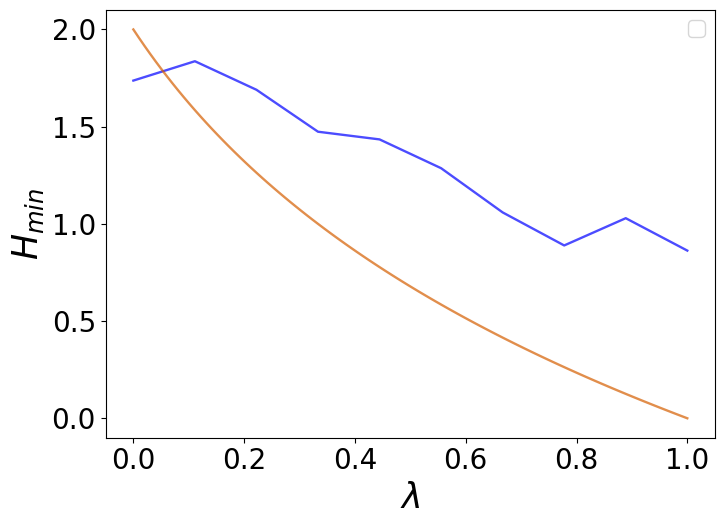

In [174]:
#Plot

marker = ["x", "o", "P", "^"]
s = [130, 100, 200, 200]

lstyles = ["dashed",
          "dotted",
          "dashdot",
          "solid",
          ]

lws = [1.7,
      3.2,
      2.2,
      1.7,
      ]

# len(color) must be \geq len(gy_list) 
color = [(float(0)/255, float(0)/255, float(255)/255), #blue
        (float(213)/255, float(94)/255,float(0)/255), #orange
        (float(255)/255, float(0)/255, float(0)/255), #red
        (float(0)/255, float(0)/255, float(0)/255), #black
        (float(0)/255, float(255)/255, float(0)/255), #green 
        ] 

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE, weight="normal", family="sans-serif")          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["figure.figsize"] = [7.50, 5.50]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = [7.50, 5.50]
plt.rcParams["figure.autolayout"] = True


    
gylabel= "$\gamma$ = {gy:.1f}"

#plt.title("Excited states energy spectrum")
x1 = lambda_set
x2 = np.linspace(0., 1., 100)

y1 = dataset.values()

y2 = []
for i in range(len(x2)):
    y2.append(H_minTheoretical(x2[i], n))
    
plt.plot(x1, y1, color=color[0], linestyle="solid", linewidth = lws[3], alpha=0.7)
plt.plot(x2, y2, color=color[1], linestyle="solid", linewidth = lws[3], alpha=0.7)

#plt.axvline(crosspoints[i],color=color[0], linewidth = lws[0], linestyle=lstyles[0])


#plt.scatter(B_VQD,E_1,color=color[0],edgecolor="white",marker=marker[0],s=s[0], label='GS')

plt.ylabel('$H_{min}$')
plt.xlabel('$\lambda$')


# Line of codes to avoid repeating labels in legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

#Arrows
#plt.annotate(text="(I)", xy=(0.2,-3), xytext=(0.05, -3.05), arrowprops={"arrowstyle":"->", "color":color[0], "lw":1.7})

plt.show()

# To do:

- Take $\lambda$ as It's a random variable with a certain probability distribution and have a look at $H_{min}$

- Change preparation circuit

## Interesting Part 1: Certification

In [37]:
def Bell_State_circ() :
    circ = Circuit(2)
    circ.H(0)
    circ.CX(0,1)
    
    return circ

In [38]:
def Bell_State_param_circ(theta):
    circ = Circuit(2)
    circ.H(0)
    circ.CX(0,1)
    circ.Ry(theta,0)
    return circ 

In [39]:
def binary_equal(a, b):
    if a == b:
        result = 0
    else:
        result = 1
    return result

In [299]:
def add_rnd_measure(circ, str1, str2):
    new_circ = Circuit(2)
    if str1 == 'X':
        new_circ.H(0)
    elif str1 != 'Z':
        print("WRONG BASE FOR QUBIT 1")
    if str2 == 'X':
        new_circ.H(1)
    elif str2 != 'Z':
        print("WRONG BASE FOR QUBIT 2")
    circ.append(new_circ)
    circ.measure_all()
    
    return circ

def execute_certificate(M, n_shots, theta):
    backend = AerBackend()
    xy_list = []
    
    shots=[]
    for i in range(n_shots):
        circ = Bell_State_circ()
        circ.Ry(theta,0)
        x = random.getrandbits(1)
        y = random.getrandbits(1)
            
        xy_list.append((x, y))
        add_rnd_measure(circ, M[0][x], M[1][y])
        
        compiled_circ = backend.get_compiled_circuit(circ)
        handle = backend.process_circuit(compiled_circ, n_shots=1)
        shots.append(backend.get_result(handle).get_shots())
            
    counts = []
    for count in shots:
        counts.append(tuple(count[0]))

    result = {x:counts.count(x) for x in counts}

    return result, counts, xy_list

In [51]:
def getIndex(x, y):
    if (x,y) == (0,0):
        index = 0
    elif (x,y) == (0,1):
        index = 1
    elif (x,y) == (1,0):
        index = 2
    elif (x,y) == (1,1):
        index = 3
        
    return index

In [73]:
def Fill_Statistics(counts, xy_list):
    """
    Takes counts and list of xy from a certificate-like circuit run
    and fill the matrix N and array P. Then compute I
    N[0][0] stands for the counts of a=0,b=0,x=0,y=0
    N[2][0] stands for the counts of a=1,b=0,x=0,y=0
    and so on
    P takes the probabilities of all the a=b or a!=b for fixed x,y
    P[0][0] = N.(sum on first row) = P(a=b|00)
    P[0][1] = N.(sum on second row)= P(a!=b|00)
    and so on
    """
    N = np.zeros([4,4])
    

    for ind in range(len(counts)):
        N[getIndex(xy_list[ind][0], xy_list[ind][1])][getIndex(counts[ind][0], counts[ind][1])] += 1
    
    P=np.zeros([4,2])
    for i in range(len(P[:])):
        P[i][0]=(N[i][0] + N[i][3])/sum(N[i][:])
        P[i][1]=(N[i][1] + N[i][2])/sum(N[i][:])
        
    I = (P[0][0] - P[0][1])
    I += (P[1][0] - P[1][1])
    I -= (P[2][0] - P[2][1])
    I += (P[3][0] - P[3][1])
    return N, P, I

In [94]:
M = [['X', 'Z'], ['X', 'Z']]
n_shots = 256
theta_list = np.linspace(0.,2.,20)

data = {"N": [], "P": [], "I":[], "result":[], "counts":[], "xy_list":[]}
for theta in theta_list:
    print("theta = ", theta)
    result, counts, xy_list = execute_certificate(M, n_shots, theta)
    N, P, I = Fill_Statistics(counts, xy_list)
    data["N"].append(N)
    data["P"].append(P)
    data["I"].append(I)
    data["result"].append(result)
    data["counts"].append(counts)
    data["xy_list"].append(xy_list)
    print("I = ", I)

theta =  0.0
0
100
200
I =  2.1348374966424926
theta =  0.10526315789473684
0
100
200
I =  2.6044011544011543
theta =  0.21052631578947367
0
100
200
I =  2.805795643425772
theta =  0.3157894736842105
0
100
200
I =  2.6668997668997667
theta =  0.42105263157894735
0
100
200
I =  2.662522153300842
theta =  0.5263157894736842
0
100
200
I =  1.9614529280948851
theta =  0.631578947368421
0
100
200
I =  0.8582642089093699
theta =  0.7368421052631579
0
100
200
I =  0.009414224669791027
theta =  0.8421052631578947
0
100
200
I =  -1.0439807915217751
theta =  0.9473684210526315
0
100
200
I =  -1.5108508582400584
theta =  1.0526315789473684
0
100
200
I =  -2.3413702554308906
theta =  1.1578947368421053
0
100
200
I =  -2.912622720897616
theta =  1.263157894736842
0
100
200
I =  -2.9948277234025626
theta =  1.3684210526315788
0
100
200
I =  -2.7448028673835125
theta =  1.4736842105263157
0
100
200
I =  -2.0226784435426115
theta =  1.5789473684210527
0
100
200
I =  -1.2853754940711464
theta =  1.6842

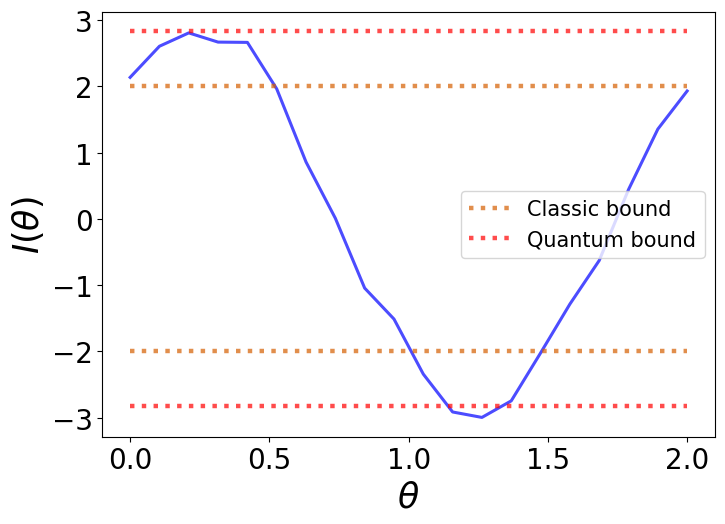

In [95]:
#Plot

marker = ["x", "o", "P", "^"]
s = [130, 100, 200, 200]

lstyles = ["dashed",
          "dotted",
          "dashdot",
          "solid",
          ]

lws = [1.7,
      3.2,
      2.2,
      1.7,
      ]

# len(color) must be \geq len(gy_list) 
color = [(float(0)/255, float(0)/255, float(255)/255), #blue
        (float(213)/255, float(94)/255,float(0)/255), #orange
        (float(255)/255, float(0)/255, float(0)/255), #red
        (float(0)/255, float(0)/255, float(0)/255), #black
        (float(0)/255, float(255)/255, float(0)/255), #green 
        ] 

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE, weight="normal", family="sans-serif")          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["figure.figsize"] = [7.50, 5.50]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = [7.50, 5.50]
plt.rcParams["figure.autolayout"] = True


    
gylabel= "$\gamma$ = {gy:.1f}"

#plt.title("Excited states energy spectrum")
x = theta_list

y = data["I"]

y1 = []
y2 = []
y3 = []
y4 = []
for i in range(len(x)):
    y1.append(2.)
    y2.append(-2.)
    y3.append(2*np.sqrt(2))
    y4.append(-2*np.sqrt(2))
    
plt.plot(x, y, color=color[0], linestyle="solid", linewidth = lws[2], alpha=0.7)
plt.plot(x, y1, color=color[1], linestyle="dotted", linewidth = lws[1], alpha=0.7, label="Classic bound")
plt.plot(x, y2, color=color[1], linestyle="dotted", linewidth = lws[1], alpha=0.7)
plt.plot(x, y3, color=color[2], linestyle="dotted", linewidth = lws[1], alpha=0.7, label="Quantum bound")
plt.plot(x, y4, color=color[2], linestyle="dotted", linewidth = lws[1], alpha=0.7)
#plt.axvline(crosspoints[i],color=color[0], linewidth = lws[0], linestyle=lstyles[0])


#plt.scatter(B_VQD,E_1,color=color[0],edgecolor="white",marker=marker[0],s=s[0], label='GS')

plt.ylabel(r"$I(\theta)$")
plt.xlabel(r"$\theta$")


# Line of codes to avoid repeating labels in legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

#Arrows
#plt.annotate(text="(I)", xy=(0.2,-3), xytext=(0.05, -3.05), arrowprops={"arrowstyle":"->", "color":color[0], "lw":1.7})

plt.show()

In [96]:
M = [['X', 'Z'], ['X', 'Z']]
n_shots = 1000
theta = 0.29 # Theta for which I is max

result, counts, xy_list = execute_certificate(M, n_shots, theta)

0
100
200
300
400
500
600
700
800
900


In [97]:
N, P, I = Fill_Statistics(counts, xy_list)

In [98]:
print("N =", N)
print("P = ", P)
print("top =", 2*np.sqrt(2))
print("ours =", I)

N = [[ 95.  15.  30. 103.]
 [114.  13.  13. 115.]
 [ 12. 112. 121.  13.]
 [ 94.  17.  22. 111.]]
P =  [[0.81481481 0.18518519]
 [0.89803922 0.10196078]
 [0.09689922 0.90310078]
 [0.84016393 0.15983607]]
top = 2.8284271247461903
ours = 2.9122374802422346


# Interesting Part 2: Randomness extraction

Let's see If It works by putting random strings as input1 and input2

In [324]:
def extractor(seeds, raws):
    # len_out = m
    # len_seed = n >= m
    # len_raws = n + m -1
    n_run = len(raws)
    len_raws = len(raws[0])
    len_seed = len(seeds[0])
    len_out = len_raws + 1 - len_seed
    
    outs = []
    
    toeplitz = cryptomite.Toeplitz(len_seed, len_out)
    for i in range(len(seeds)):
        outs.append(tuple(toeplitz.extract(seeds[i], raws[i])))
        
    return outs

In [289]:
# Build raw inputs and seeds

H_bound = 1.
n_run = 3
n_shots = 5
len_seed = n_shots*2 - int(2*H_bound) + 1

raws = []
for row in range(n_run):
    partial_raw = []
    for column in range(2*n_shots):
        partial_raw.append(random.getrandbits(1))
    raws.append(partial_raw)

seeds = []
for row in range(n_run):
    partial_seed = []
    for column in range(len_seed):
        partial_seed.append(random.getrandbits(1))
    seeds.append(partial_seed)

In [290]:
outs = extractor(seeds, raws)

In [291]:
outs 

[(0, 0), (1, 0), (0, 0)]

### Tries with H-CNOT circuit which sends |0> into |uniform>, but with the toy noise model (lambda gets changed every run)

In [279]:
def run_diff_lambdas(circ, n_run, n_shots, model="One lambda"):
    run_lambdas = []
    lam = []
    H_mins = []
    
    for i in range (n_run):
        lam.append(random.uniform(0,1))
        a, b = run(circ, lam[i], n_shots, model)
        bis = list(itertools.chain(*b))
        run_lambdas.append(bis)
        H_mins.append(H_min_new(a)[0])
        
    return(run_lambdas,lam,H_mins)

In [280]:
n = 2
circ = Had_CNOT_circ(n)

In [281]:
n_run = 100
n_shots = 5 # little shots

raws, lam, H_mins = run_diff_lambdas(circ, n_run, n_shots)

In [283]:
H_bound = 1.3 # To compute or to look in previous sections
len_seed = n_shots*n - n*int(H_bound) + 1

seeds = []
for row in range(n_run):
    partial_seed = []
    for column in range(len_seed):
        partial_seed.append(random.getrandbits(1))
    seeds.append(partial_seed)

In [284]:
outs = extractor(seeds, raws)

In [285]:
def H_from_extractor(outs):
    
    List = Counter(outs)
    H = -np.log2((1*List.most_common(1)[0][1])/len(outs))
    return H

In [287]:
print("H_min from extractor = ", H_from_extractor(outs))
print("H_min from circ runs = ", np.average(H_mins))
print("H_min maximum possible = ", n)

H_min from extractor =  1.7858751946471527
H_min from circ runs =  0.8315045327011527
H_min maximum possible =  2


### Tries with certificate results

Now implement a true instance of the certificate.
- An experiment is made of some runs of few shots circuit. Each run has the theta max.
- Check If the experiment has a good I.
- If It's the case, extract a "truly random" bit for each run.
- Do a lot of experiments and have a look at the H_min

In [340]:
def update_counts(r1, r2):
    r3 = {}
    for key in r1.keys():
        r3[key] = r1[key]
        if key in r2.keys():
            r3[key] += r2[key]
        
    return r3

In [348]:
def certificate_experiment(n_shots, n_runs, theta):
    """
    JUST FOR 2 QUBIT, OTHERWISE CHANGE n AND OTHER
    """
    n = 2
    M = [['X', 'Z'], ['X', 'Z']]
    H_circ = []
    partial_result = {(0, 1): 0, (0, 0): 0, (1, 1): 0, (1, 0): 0}
    raws = []
    
    for i in range(n_runs):
        result, counts, xy_list = execute_certificate(M, n_shots, theta)
        updated_result = update_counts(partial_result, result)
        N, P, I = Fill_Statistics(counts, xy_list)
        raws.append(list(itertools.chain(*counts)))
        
        if I > 2:
            H_bound = 1. # To compute or to look in previous sections
            len_seed = n_shots*n - n*int(H_bound) + 1

            seeds = []
            for row in range(n_runs):
                partial_seed = []
                for column in range(len_seed):
                    partial_seed.append(random.getrandbits(1))
                seeds.append(partial_seed)
            
            partial_result = updated_result
            
    H_from_circ = H_min_new(updated_result)[0]
    outs = extractor(seeds, raws)
    H = H_from_extractor(outs)
    return(outs, H, H_from_circ)

In [365]:
# Cell to try for one experiment

n_shots = 5
n_runs = 10
theta = 0.25

outs, H, H_from_circ = certificate_experiment(n_shots, n_runs, theta)
print(outs)
print(H)
print(H_from_circ)

[(0, 1), (0, 0), (0, 1), (1, 0), (1, 0), (0, 1), (1, 1), (1, 0), (0, 1), (1, 1)]
1.3219280948873622
0.9068905956085186


In [366]:
n_experiments = 10
n_shots = 5
n_runs = 50
theta = 0.25

res_outs = []
res_H = []
res_H_from_circ = []
for exp in range(n_experiments): 
    outs, H, H_from_circ = certificate_experiment(n_shots, n_runs, theta)
    res_outs.append(outs)
    res_H.append(H)
    res_H_from_circ.append(H_from_circ)

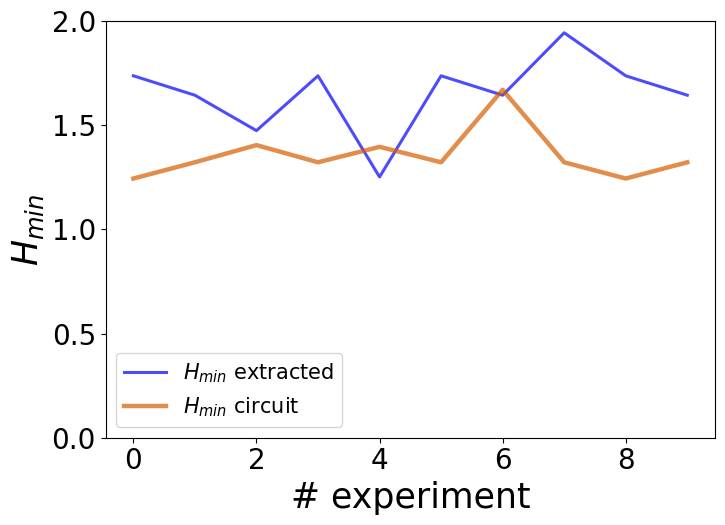

In [370]:
#Plot

marker = ["x", "o", "P", "^"]
s = [130, 100, 200, 200]

lstyles = ["dashed",
          "dotted",
          "dashdot",
          "solid",
          ]

lws = [1.7,
      3.2,
      2.2,
      1.7,
      ]

# len(color) must be \geq len(gy_list) 
color = [(float(0)/255, float(0)/255, float(255)/255), #blue
        (float(213)/255, float(94)/255,float(0)/255), #orange
        (float(255)/255, float(0)/255, float(0)/255), #red
        (float(0)/255, float(0)/255, float(0)/255), #black
        (float(0)/255, float(255)/255, float(0)/255), #green 
        ] 

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE, weight="normal", family="sans-serif")          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["figure.figsize"] = [7.50, 5.50]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = [7.50, 5.50]
plt.rcParams["figure.autolayout"] = True


    
gylabel= "$\gamma$ = {gy:.1f}"

#plt.title("Excited states energy spectrum")
x = np.arange(n_experiments)

y1 = res_H
y2 = res_H_from_circ
    
plt.plot(x, y1, color=color[0], linestyle="solid", linewidth = lws[2], alpha=0.7, label=r"$H_{min}$ extracted")
plt.plot(x, y2, color=color[1], linestyle="solid", linewidth = lws[1], alpha=0.7, label=r"$H_{min}$ circuit")
#plt.axvline(crosspoints[i],color=color[0], linewidth = lws[0], linestyle=lstyles[0])


#plt.scatter(B_VQD,E_1,color=color[0],edgecolor="white",marker=marker[0],s=s[0], label='GS')

plt.ylabel(r"$H_{min}$")
plt.xlabel(r"# experiment")
plt.ylim([0, 2])

# Line of codes to avoid repeating labels in legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

#Arrows
#plt.annotate(text="(I)", xy=(0.2,-3), xytext=(0.05, -3.05), arrowprops={"arrowstyle":"->", "color":color[0], "lw":1.7})

plt.show()

$H_{min}$ is generally higher after the randomness extractor. Should in any case be less than 1? Think about It.